In [1]:
import madmom
import librosa
import utils
import matplotlib.pyplot as plt
import numpy as np

beat_processor = madmom.features.downbeats.DBNDownBeatTrackingProcessor(2,fps=100)
activation_processor =  madmom.features.downbeats.RNNDownBeatProcessor()
path = "/home/max/ET-TI/Masterarbeit/mirdata/beatles/"
title = "06_-_Rubber_Soul/11_-_In_My_Life"
activations = activation_processor(path+"audio/"+title+".wav")
beats = beat_processor(activations)



/home/max/.local/lib/python3.10/site-packages/madmom/features/downbeats.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  best = np.argmax(np.asarray(results)[:, 1])


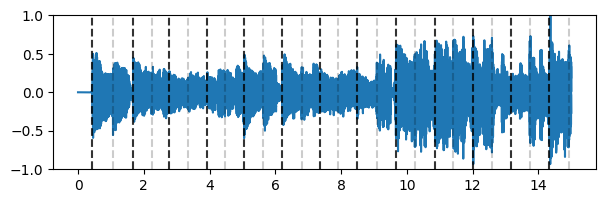

In [4]:
y,sr = librosa.load(path+"audio/"+title+".wav",duration=15)
fig,ax = plt.subplots(figsize=(7,2))
utils.plotAudioWaveform(ax,y/np.max(y),time_interval=(0,15),beats=beats,downbeats=True)

In [6]:
import librosa
import features
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mir_eval
import utils
import transcribe
import circularPitchSpace as cps

def chordRecognition(chromavector,threshold=0.1):
    notes = applyNoteThreshold(templates[i,:],threshold)
    chord = stackThirds(notes) 
    if not chord:
        return "N"

    pc_index,label,n_f = getNoteLabels(chord,key)
    getNotesInKey(pc_index,n_f)
    # project chord onto pitch space
    r_fr = r_tr = r_f = 0
    for j in range(len(pc_index)):
        n_fr = cps.sym(n_f[j] - 7*n_k, 48)
        n_tr = cps.sym(n_f[j] - 7*n_k - 12, 24)
        r_f +=  templates[i,pc_index[j]] * np.exp(-1j*2*np.pi*(n_f[j]/84))
        r_fr += templates[i,pc_index[j]] * np.exp(-1j*2*np.pi*(n_fr/48))
        r_tr += templates[i,pc_index[j]] * np.exp(-1j*2*np.pi*(n_tr/24))
    # plot vector
    cps.plotVector(axes[0],r_f,color = colors[i%len(colors)])
    cps.plotVector(axes[1],r_fr,color = colors[i%len(colors)])
    cps.plotVector(axes[2],r_tr,color = colors[i%len(colors)])

    root = label[0]
    quality=""
    intervals = [y-x for x,y in itertools.pairwise(pc_index)]
    # TRIAD
    if len(intervals) == 2: 
        if intervals ==  [4,3]:
            quality = "maj"
        elif intervals ==  [3,4]:
            quality = "min"
        elif intervals ==  [3,3]:
            quality = "dim"
        elif intervals == [4,4]:
            quality = "aug"
    # TETRACHORD
    elif len(intervals) == 3:
        if intervals ==  [4,3,3]:
            quality = "7"
        elif intervals ==  [4,3,4]:
            quality = "maj7"
        elif intervals ==  [3,4,3]:
            quality = "min7"
        elif intervals == [3,4,4]:
            quality = "minmaj7"
        elif intervals == [3,3,3]:
            quality = "dim7"
        elif intervals == [3,3,4]:
            quality = "hdim7"
    elif len(intervals) > 3:
        quality="9"
    return mir_eval.chord.join(root, quality)


def applyNoteThreshold(chromavector,threshold):
    notes = np.argwhere(chromavector > threshold).flatten().tolist()
    return notes

def stackThirds(notes):
    for note_combination in itertools.permutations(notes,len(notes)):
        valid_chord = True
        for interval in itertools.pairwise(note_combination):
            diff = interval[1] - interval[0]
            if(interval[1] - interval[0]) < 0:
                diff = interval[1] - interval[0] + 12 
            if diff < 3 or diff > 4:
                valid_chord = False
                break
        if valid_chord:
            break
    if valid_chord:
        return note_combination
    else:
        return None

def getNoteLabels(chord_pc_index,key):
    chord_nf = []
    chord_labels = []
    missing_notes = []
    # calculate index n_f for each note
    for i,chroma_index in enumerate(chord_pc_index):
        n_c = cps.pitch_classes[chroma_index].chromatic_index
        n_f = sym3(49*n_c,84,7*n_k)
        if -21 <= (n_f-7*n_k) <= 21:
            chord_nf.append(n_f)
            chord_labels.append(cps.pitch_classes[chroma_index].name)
        else:
            # calculate both possible indices for enharmonic notes
            n_f_0 = (accidentals[cps.pitch_classes[chroma_index].name] - 2) * 7
            n_f_1 = (accidentals[cps.enharmonic_notes[cps.pitch_classes[chroma_index].name]] - 2) * 7
            chord_nf.append([n_f_0,n_f_1])
            chord_labels.append(None)
            missing_notes.append(i)

    for start_index in itertools.cycle(missing_notes):
        try:
            # find first missing label
            start_index = chord_labels.index(None,start_index)
            # check if missing label is at start, end or in between and find a fitting chordlabel
            if start_index == 0:
                # if there is an existing note next to our missing note, we can find the best match
                if(chord_labels[start_index+1]):
                    diff_0 = abs(chord_nf[start_index+1] - chord_nf[start_index][0])
                    diff_1 = abs(chord_nf[start_index+1] - chord_nf[start_index][1])
                else:
                    continue
            else:
                if(chord_labels[start_index-1]):
                    diff_0 = abs(chord_nf[start_index-1] - chord_nf[start_index][0])
                    diff_1 = abs(chord_nf[start_index-1] - chord_nf[start_index][1])
                else:
                    if(chord_labels[start_index+1]):
                        diff_0 = abs(chord_nf[start_index+1] - chord_nf[start_index][0])
                        diff_1 = abs(chord_nf[start_index+1] - chord_nf[start_index][1])
                    else:
                        continue
            # evaluate distance in TR and pick the note closer to its neighbouring note.
            if diff_0 < diff_1:
                chord_labels[start_index] = cps.pitch_classes[chord_pc_index[start_index]].name
                chord_nf[start_index] = chord_nf[start_index][0]
            else:
                chord_labels[start_index] = cps.enharmonic_notes[cps.pitch_classes[chord_pc_index[start_index]].name]
                chord_nf[start_index] = chord_nf[start_index][1]
        except ValueError:
            # no missing chord labels found after starting index
            if len([x for x in chord_labels if x is None]) == 0:
                break
            else:
                continue
    return chord_pc_index,chord_labels,chord_nf
    
def transcribe(chroma):
    pass
plt.rcParams['text.usetex'] = True

start = 0
stop = 30
path = "/home/max/ET-TI/Masterarbeit/mirdata/beatles/"
# title = "06_-_Rubber_Soul/11_-_In_My_Life"
title = "12_-_Let_It_Be/06_-_Let_It_Be"
# title = "10CD1_-_The_Beatles/CD1_-_17_-_Julia"

y,sr = librosa.load(path+"/audio/"+title+".wav",offset=start,duration=stop-start)
target = mir_eval.io.load_labeled_intervals(path+"/annotations/chordlab/The Beatles/"+title+".lab",' ','#')
chroma = features.crpChroma(y)
time_vector = np.linspace(start, stop, chroma.shape[0], endpoint=False) 
rho_F,rho_FR,rho_TR,rho_DR = cps.transformChroma(chroma)
pc_energy = cps.getPitchClassEnergyProfile(chroma,threshold=0.6,angle_weight=0.6)
chroma_energy = np.square(chroma)
xticks = np.arange(0,chroma.shape[0],50)
xticklabels = np.round(time_vector[xticks],1)
fig,ax = plt.subplots(2,1)
img = ax[0].imshow(pc_energy.T,origin='lower',aspect='auto')
ax[0].plot(np.argmax(pc_energy,axis=1),'or',markersize=2)
fig.colorbar(img)
pc_energy_filtered = np.zeros_like(pc_energy)
alpha = 0.96
for i in range(1,pc_energy.shape[0]):
    pc_energy_filtered[i,:] = alpha * pc_energy_filtered[i-1,:] + (1-alpha) * pc_energy[i,:]
img = ax[1].imshow(pc_energy_filtered.T,origin='lower',aspect='auto')
ax[1].plot(np.argmax(pc_energy_filtered,axis=1),'or',markersize=2)
fig.colorbar(img)
for x in ax:
    x.set_yticks([0,2,4,5,7,9,11])
    x.set_yticklabels(["C","D","E","F","G","A","B"])
    x.set_ylabel("Key")
ax[0].set_xticks([])
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticklabels)
ax[1].set_xlabel("time in s")   

IndentationError: expected an indented block after function definition on line 141 (2374143839.py, line 143)

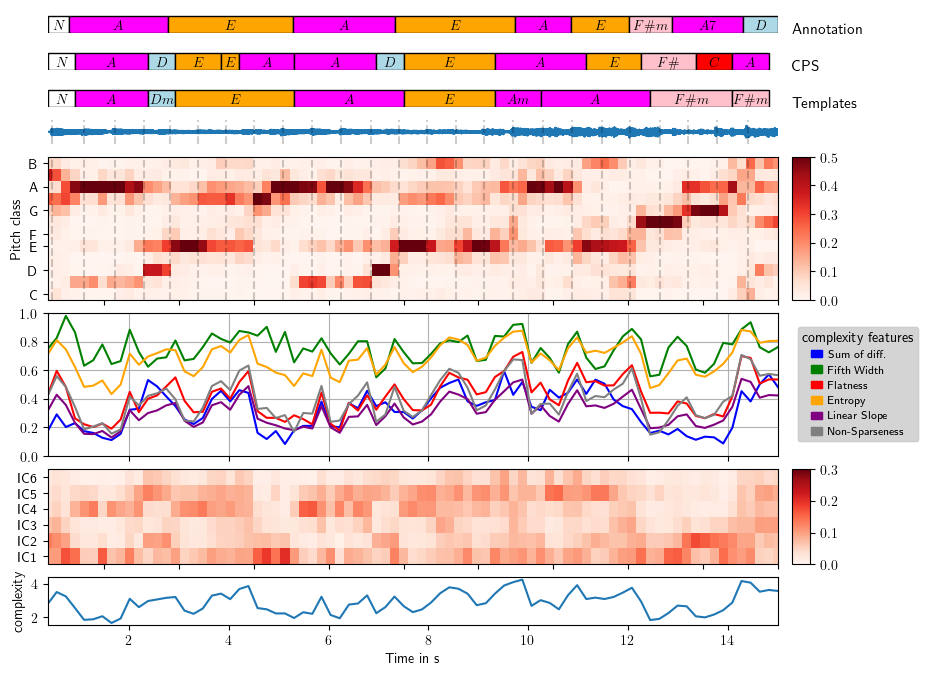

In [ ]:

############ Parameters ##########
N = 2**14
hop_length = N//4
# chroma = features.crpChroma(y,n=N,overlap=N-hop_length)
# chroma = features.clpChroma(y,sr,4410)
chroma = features.librosaChroma(y,hop_length=hop_length)
align_chroma = False
#############################


tempo, beats = librosa.beat.beat_track(y=y, sr=sr,units='time')
# activations_processor = madmom.features.beats.RNNBeatProcessor()
# beat_processor = madmom.features.beats.BeatTrackingProcessor(fps=100)
# beats = beat_processor(activations_processor(path+"/audio/"+title+".wav"))

# adjust time offset
beats += start
if align_chroma:
    chroma = features.alignChroma(chroma,beats,(start,stop),filtering=True)
time_vector = np.linspace(start + (N//2)/sr, stop, chroma.shape[0], endpoint=True)
complexity_features = [ 
                        features.sumChromaDifferences(chroma),
                        features.angularDeviation(chroma),
                        features.flatness(chroma),
                        features.shannonEntropy(chroma),
                        features.negativeSlope(chroma),
                        features.nonSparseness(chroma)
                       ] 
complexity = np.sum(np.array(complexity_features),axis=0)
estimation_cps = transcribe.transcribeCPS(time_vector,chroma,complexity,3.8,0.2)
estimation_templates = transcribe.transcribeTemplates(time_vector,chroma,complexity,3.8,0.4)
intervals = features.intervalCategories(chroma)

utils.plotFeatures(start,stop,time_vector,y,chroma,beats,complexity_features,intervals,target,estimation_cps,estimation_templates);